# Image Classification

## Objective
The purpose of this image classification project is to be able to identify single fruit and vegetable from an input picture.

The classifier model will be able to discriminate between 131 distinct labels.

## Tools
The main tools used are the following:

### Environment
Google colab

### Librairies


* Tensorflow/Keras
* Seaborn/Matplotlib
* Pillow








## Data Gathering
Training data is downloaded from *Kaggle*.

The dataset used is *Fruits 360* found [here](https://www.kaggle.com/datasets/moltean/fruits/code).

The data consists of 100*100 RGB pictures in JPEG format taken by a Logitech C920 camera with a white sheet of paper as background. The background, however, were artificially replaced using an algorithm.

This dataset purpose is mainly for model training and deep learning practice.

### License
The data is licensed under *MIT License*:

>Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
>
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

### Ethics
There is no apparent ethics concern when using this dataset, as it only contains pictures of fruits and vegetables.

### Downloading data
*Kaggle's API* was used to download data directly on *kaggle*. This piece of code is not meant to be reproducible on an external environment. The dataset can be easily downloaded from the source.

### Confidentiality
In order to guarantee confidentiality of credentials they will be read from a google drive and not wrote explicitly or uploaded alongside the notebook.

In [8]:
import json
import os
from os import listdir
from google.colab import drive
!pip install kaggle --quiet

try: 
  if 'fruits-360_dataset' in listdir():
    raise FileExistsError('Dataset already exists')

  drive.mount('/content/drive', force_remount=True)
  os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/Colab Notebooks/"

  !kaggle datasets download -d moltean/fruits
  !unzip fruits.zip

  drive.flush_and_unmount()

except Exception as e:
  print("Only necessary during creation of the project")
  print(e)

Only necessary during creation of the project
Dataset already exists


## Data understanding


### Labels
Number of labels should be equivalent in training and test sets. According to documentation it is expected to find *131* of them.

In [9]:
from os.path import join, isfile

directory = join(os.getcwd(),"fruits-360_dataset", "fruits-360")
#directory = join(os.getcwd(),"fruits-360-original-size", "fruits-360-original-size")

training_dir = join(directory, 'Training')
test_dir = join(directory, 'Test')

training_labels = listdir(training_dir)
test_labels = listdir(test_dir)

# Number of labels

# Verify all labels are present in both datasets
assert len(training_labels) == len(test_labels)
# According to documentation about dataset there should be 131 labels
assert len(training_labels) == 131

# We save the label numbers for the last layer of our model
LABELS_NUM = len(training_labels)
print(f'Number of labels:  {LABELS_NUM}')




Number of labels:  131


### Entries
By looking at the documentation on Kaggle it is expected to have:




>Training set size: 67692 images (one fruit or vegetable per image).
>
>Test set size: 22688 images (one fruit or vegetable per image).
>
>The total number of images: 90483.




In [10]:
# Number of entries per dataset
def find_number_entries(dataset_directory: str):
  number_entries = len([entries for label in listdir(dataset_directory) for entries in listdir(join(dataset_directory, label))])

  dataset_name = dataset_directory.split('/')[-1]
  print(f'There are {number_entries} entries for the {dataset_name} dataset')
  return number_entries

training_entries_num = find_number_entries(training_dir)
test_entries_num = find_number_entries(test_dir)
print(f'The total number of images is: {training_entries_num + test_entries_num}')


There are 67692 entries for the Training dataset
There are 22688 entries for the Test dataset
The total number of images is: 90380


The number matches, but the total given in documentation is probably including multiple fruits images. 67692 + 22688 do not equal to 90483. It simple to test this hypothesis.

In [11]:
multiple_fruits = join(directory, 'test-multiple_fruits')
len(listdir(multiple_fruits)) + training_entries_num + test_entries_num

90483

### Image inspection
The first image of the training dataset will be inspected to check for metadata. This will give an idea of what to expect and helps us cleaning data.

The expectations according to documentaiton are:
*   format: .jpg
*   shape: (100,100)
*   mode: RGB



format: JPEG
shape: (100, 100)
mode: RGB

This is the first image of the label: Kumquats


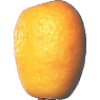

In [12]:
!pip install Pillow --quiet
from PIL import Image

# Image format
first_label = listdir(training_dir)[0]
first_label_path = join(training_dir, first_label)

first_image_name = listdir(first_label_path)[0]
first_image_path = join(first_label_path,  first_image_name)
first_image = Image.open(first_image_path)

print(f"format: {first_image.format}")
print(f"shape: {first_image.size}")
print(f"mode: {first_image.mode}")

print(f"\nThis is the first image of the label: {first_label}")
display(first_image)

## Data Cleaning
To simplify the model training pipeline, only the images falling under the above metadata will be kept. 

Although in the present case it is already known that every image have been curated and cleaned accordingly, a data cleaning process should be present in every pipeline to be able to bring some additional data later on.

In [13]:
IMAGE_FORMAT = 'JPEG'
IMAGE_SIZE = (100,100)
IMAGE_MODE = 'RGB'

def is_valid_image_format(image_path: str):
  image = Image.open(image_path)
  valid_format = image.format == IMAGE_FORMAT
  valid_shape = image.size == IMAGE_SIZE
  valid_mode = image.mode == IMAGE_MODE

  return (    valid_format
          and valid_shape
          and valid_mode)

def clean_dataset(dataset_directory: str):
  cleaned_dataset = {}
  removed_counter = 0
  kept_counter = 0

  dataset_name = dataset_directory.split('/')[-1]

  for label in listdir(dataset_directory):
    label_name = label.split('.')[0]
    label_cleaned_data = []
    label_directory = join(dataset_directory, label)

    for image in listdir(label_directory):
      image_path = join(label_directory,  image)

      if is_valid_image_format(image_path):
        label_cleaned_data.append(image_path)
        kept_counter += 1

      else: 
        # Here should be the function to remove file or move it elsewhere
        removed_counter += 1
      
    cleaned_dataset[label_name] = label_cleaned_data

  print(f"{removed_counter} images were removed: {kept_counter} are left for the {dataset_name} dataset.")
  return cleaned_dataset
  
# Note: these information are not used to clean the directories
clean_training = clean_dataset(training_dir)
clean_test = clean_dataset(test_dir)

0 images were removed: 67692 are left for the Training dataset.
0 images were removed: 22688 are left for the Test dataset.


## Data exploration

### Sets balance
The balance of datasets can impact the end results, in order to anticipate any issues it can be simply plotted.

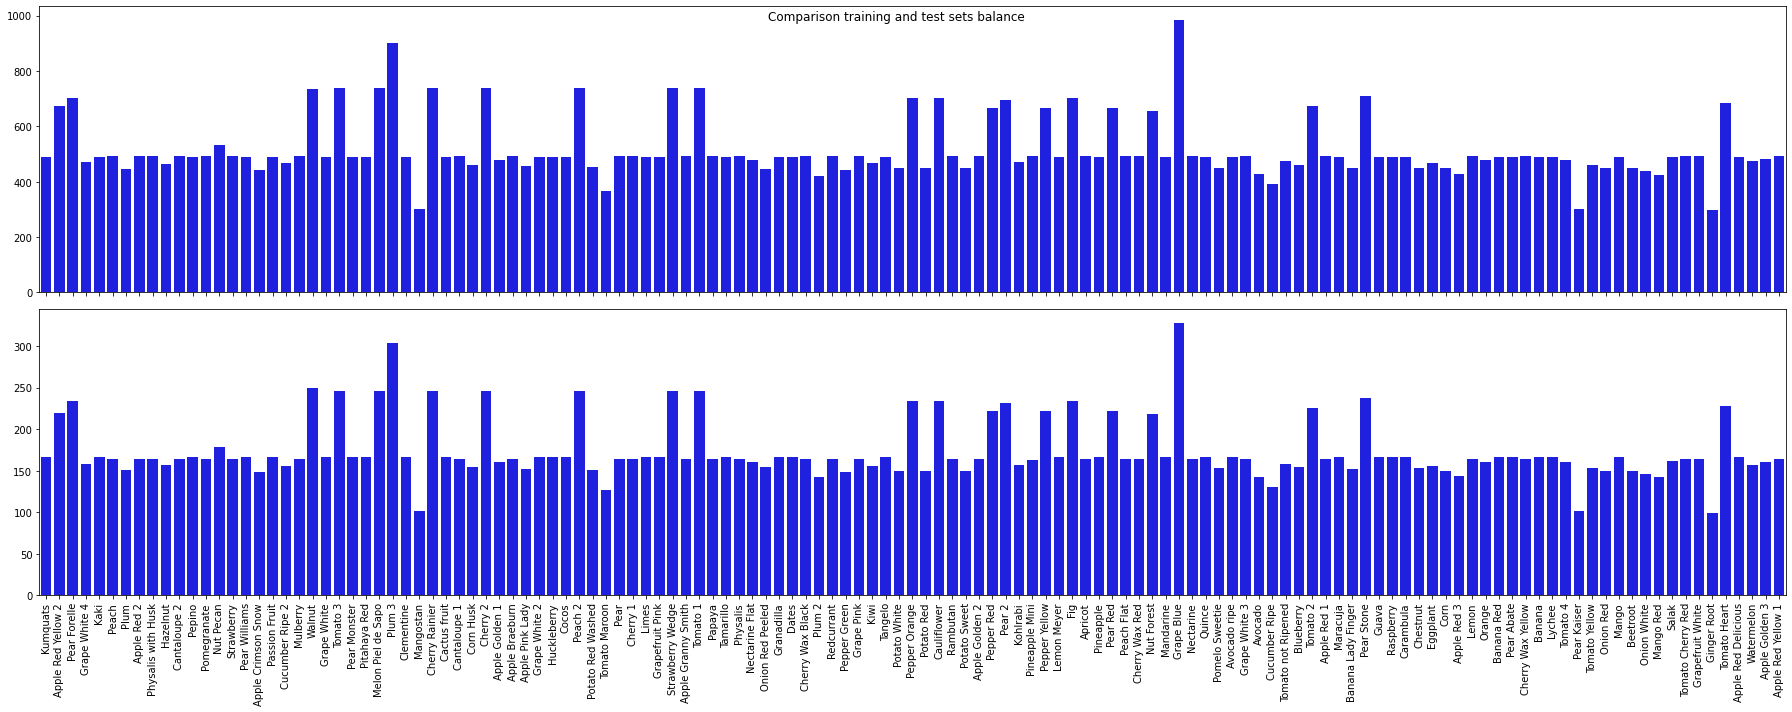

In [14]:
from matplotlib import figure
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def get_dataset_balance(cleaned_dataset):
  labels_frequency = {}
  for label, images in cleaned_dataset.items():
    labels_frequency[label] = len(images)

  return labels_frequency

def plot_frequencies():
  training_frequency = get_dataset_balance(clean_training)
  training_series = pd.Series(training_frequency)

  test_frequency = get_dataset_balance(clean_test)
  test_series = pd.Series(test_frequency)

  fig, axes = plt.subplots(2,1, sharex=True,figsize=(25,10))
  fig.suptitle('Comparison training and test sets balance')

  sns.barplot(x=training_series.index, y=training_series.values, color='blue', ax=axes[0])
  sns.barplot(x=training_series.index, y=test_series.values, color='blue', ax=axes[1])
  plt.xticks(rotation=90)
  fig.tight_layout()
  plt.show()

plot_frequencies()



At least the training and testing datasets are similarly balanced, this will avoid validation and overfitting issues. 

In case some labels are hard to predict because of missing training data (such as Pearl Kaiser) some more data can be collcected.

## Processing Data
The data need to be processed before feeding it to the model that will be created later.

### Importing downloaded data
Dataset are read directly from their respective directory and labels are inferred from the directory structure.

In [15]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

BATCH_SIZE = 32

train_generator = image_dataset_from_directory(directory=training_dir,
                                             labels='inferred',
                                             label_mode='categorical',
                                             class_names=os.listdir(training_dir),
                                             color_mode=IMAGE_MODE.lower(),
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE,
                                             shuffle=True,
                                             seed=42)


Found 67692 files belonging to 131 classes.


### Test and validation split
The original dataset only provide training and tests subsets, but in order to avoid overfitting during parameters tuning test set should not be used as validation.

A validation set will be used to access accuracy on non-optimized training, but a test set will serve as guarantee that the model was not fitted only to obtain high validation accuracy.


In [16]:
# The image_dataset_from_directory is meant to divide between training and validation,
# so the subset argument value is misleading, unfortunately only 'validation', 'training' and None are acceptable values
validation_generator = image_dataset_from_directory(directory=test_dir,
                                                  labels='inferred',
                                                  label_mode='categorical',
                                                  class_names=listdir(test_dir),
                                                  color_mode=IMAGE_MODE.lower(),
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  seed=42,
                                                  validation_split=0.2,
                                                  subset='training'
                                                  )

test_generator = image_dataset_from_directory(directory=test_dir,
                                              labels='inferred',
                                              label_mode='categorical',
                                              class_names=listdir(test_dir),
                                              color_mode=IMAGE_MODE.lower(),
                                              batch_size=1,
                                              image_size=IMAGE_SIZE,
                                              shuffle=True,
                                              seed=42,
                                              validation_split=0.2,
                                              subset='validation'
                                              )

Found 22688 files belonging to 131 classes.
Using 18151 files for training.
Found 22688 files belonging to 131 classes.
Using 4537 files for validation.


### Features normalization
In the case of rgb pictures the pixels values for each channel have to be divided by 255 to obtain a float value between 0.0 to 1.0 

In [17]:
rescale = Rescaling(scale=1.0/255)

def features_normalization(generator):
  return generator.map(lambda image, label:(rescale(image),label))


train_generator = features_normalization(train_generator)
validation_generator = features_normalization(validation_generator)
test_generator = features_normalization(test_generator)

## Model building
The obvious choice for image classification is via a deep Convolutional Neural Network (CNN). But an review of already implemented options should be explored beforehand.


### Literature review
#### CNN from scratch
The author of the dataset is also an author of a research paper: [Fruit recognition from images using deep learning](https://www.researchgate.net/publication/321475443_Fruit_recognition_from_images_using_deep_learning).

Their model architecture is composed of 4 Convolution/max-pooling layers followd by 2 fully connected layers. The hyperparameters (such as number of filters per layers) have been experimented with; the details will not be given here but can be found on page 18-25 on the original paper linked above.

They easily reached above 95% test set accuracy for most variation, their best score being 98.66%. There seems to be a very good score, so there is no need to search for very different architecture on this problem.


#### Transfer learning
Another approach that has been tried and can be found on [*Kaggle*](https://www.kaggle.com/code/alpayabbaszade/vgg16-with-keras-fruits-360-dataset) is the use of transfer learning, mainly using VGG16 pre-trained algorithm.

Other similar attempt have been made, but by focusing on the link shared above: they reached a very respectable validation accuraccy of 97.41%. Although the score is inferior to the original paper, the main reason for not using similar approach is that transfer learning algorithms can be cumbersome to train, necessitating a lot of epochs with small initial training steps. [1]

In the above mentionned trial they apparently managed this in 5 epochs, but they do not give any test accuracy, so the result could be overfit.

In conclusion a relatively simple CNN seem to be an amazing work at solving this issue, so it does not appear advantageous to rely on heavy and long to fit pre-trained model, such as VGG16 or AlexNet.

### Custom model
The final model's architecture chosen for this task is the following:

*   Input layer
*   4 Convolution + 4 Maxpooling
*   2 Fully connected layer
*   Output layer



In [18]:
from keras.layers import Dense, MaxPooling2D, Conv2D, Dropout, Flatten, BatchNormalization
from keras.models import Sequential

model = Sequential([
                    Conv2D(filters = 16, kernel_size = (3,3), input_shape=(100,100,3)),
                    BatchNormalization(),
                    MaxPooling2D(pool_size=(2,2)),
                    
                    Conv2D(filters = 32, kernel_size = (3,3), activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D(pool_size=(2,2)),

                    Conv2D(filters = 32, kernel_size = (3,3), activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D(pool_size=(2,2)),

                    Conv2D(filters = 64, kernel_size = (3,3), activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D(pool_size=(2,2)),

                    Flatten(),
                    Dense(1024, activation='relu'),
                    Dropout(0.5),
                    Dense(512, activation='relu'),
                    Dropout(0.5),
                    Dense(LABELS_NUM, activation='softmax')
                    ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 47, 47, 32)       128       
 hNormalization)                                                 
                                                        

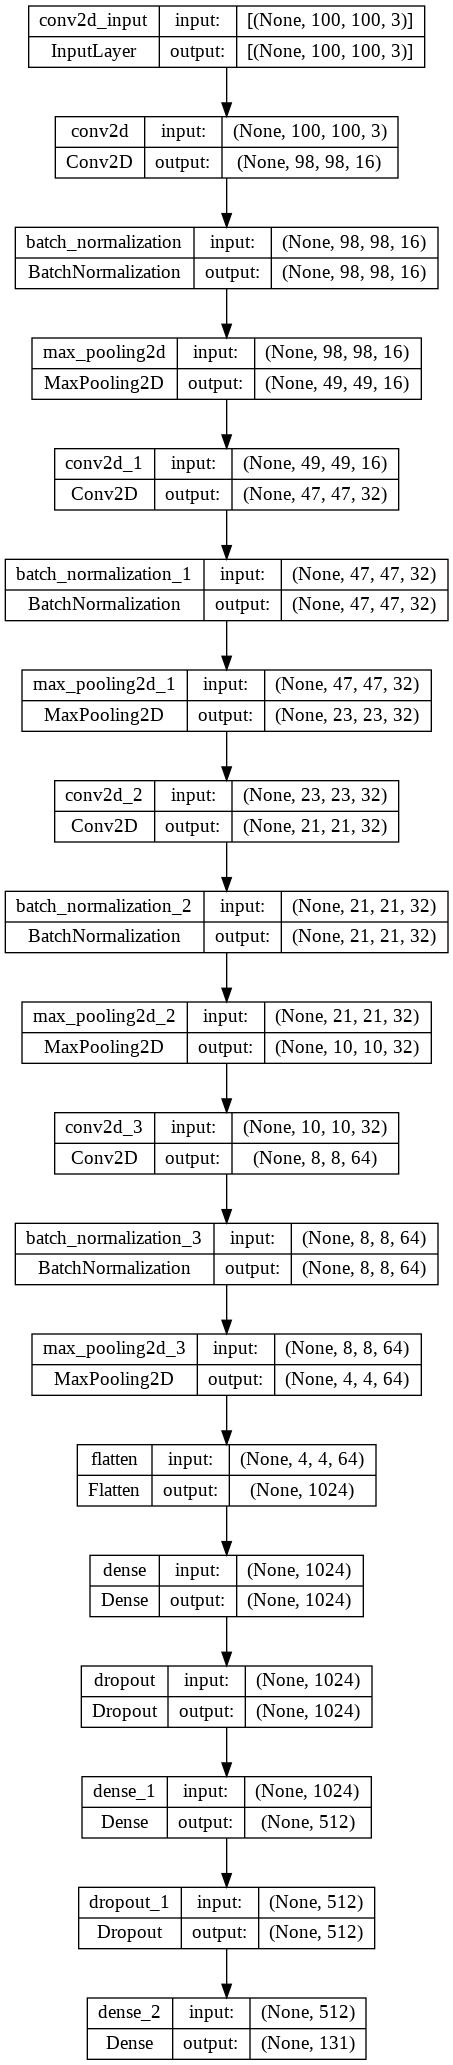

In [19]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_architecture_fruits360.png', show_shapes=True, show_layer_names=True)

### Model compilation
The calculation of loss will be gone throuh *categorical cross entropy* (the classification being multi-class classification), the optimizer will be the polyvalent *adam* and the metrics of choice will be accuracy.

These choices are all very common but sensible. The author of the research paper used *Adadelta*, *sparse categorical cross entropy* and accuracy. 

Adam is a more advanced extension of adadelta adding momentum to the learning rate, therefore it seems to have no benefit of using adadelta over adam although both should work really well. [2]

Our data preprocessing not being the same: they used 'sparse' (page 32) where I used 'categorical', however the loss calculation is the same for both. [3]

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Model Training
The model is run on 30 epochs, with early stopping if the model do not improve over 5 epochs. The best weights will be kept both ways and saved in a hdf5 file.

The training happens on cloud GPUs for much better efficiency, however the entire process is still taking a significant amount of time, therefore the model and its performances will be saved for later use if necessary.


In [55]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

EPOCHS = 30

def save_model(model, history, name: str):
  model.save(name)

  with open (name + '.json', 'w') as f:
    json.dump(history.history, f)

  print(f'{name} model was saved')

def run_model(model, name: str, epochs: int=10):
  # Save only  the best weights
  best_weights = ModelCheckpoint(filepath = name + '.hdf5', monitor='val_loss', verbose = 1, save_best_only = True)
  # Stop when the model stop lowering down the validation loss
  early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

  return model.fit(train_generator,
                   epochs=epochs,
                   validation_data=validation_generator,
                   callbacks = [best_weights, early_stopping]
                  )
  

def run_and_save_model(model, name: str, epochs: int=10):
    history = run_model(model, name, epochs)
    save_model(model, history, name)
    return history

history = run_and_save_model(model, 'CNN4', epochs=EPOCHS)

# N.B the output below does not necessarily correspond to the first run of the model being trained

Epoch 1/30
2112/2116 [============================>.] - ETA: 0s - loss: 0.0861 - accuracy: 0.9819
Epoch 1: val_loss improved from inf to 0.17867, saving model to CNN4.hdf5
2116/2116 [==============================] - 51s 24ms/step - loss: 0.0860 - accuracy: 0.9819 - val_loss: 0.1787 - val_accuracy: 0.9693
Epoch 2/30
2112/2116 [============================>.] - ETA: 0s - loss: 0.0503 - accuracy: 0.9884
Epoch 2: val_loss did not improve from 0.17867
2116/2116 [==============================] - 49s 23ms/step - loss: 0.0503 - accuracy: 0.9884 - val_loss: 0.2127 - val_accuracy: 0.9670
Epoch 3/30
2111/2116 [============================>.] - ETA: 0s - loss: 0.0435 - accuracy: 0.9898
Epoch 3: val_loss did not improve from 0.17867
2116/2116 [==============================] - 54s 26ms/step - loss: 0.0436 - accuracy: 0.9898 - val_loss: 0.2291 - val_accuracy: 0.9661
Epoch 4/30
2113/2116 [============================>.] - ETA: 0s - loss: 0.0358 - accuracy: 0.9912
Epoch 4: val_loss did not improve f

CNN4 model was saved


## Model Evaluation
To evaluate the model in such a classic *multi-class classification* accuracy and loss remain the most useful metrics. [4]

Evolution of loss and accuracy accross epochs comparing training with validation will be the evaluation of choice. Both will be plotted accordingly.

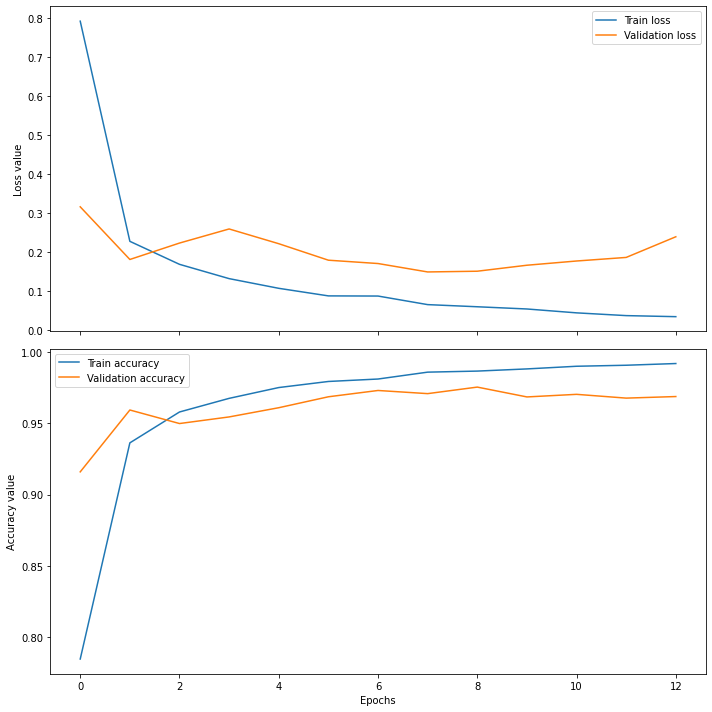

In [22]:
def plot_performance(history):
  loss, accuracy, val_loss, val_accuracy = history.values()

  fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,10))
  sns.lineplot(ax=axes[0], x=range(len(loss)), y=loss, label='Train loss')
  sns.lineplot(ax=axes[0], x=range(len(val_loss)), y=val_loss, label='Validation loss')
  
  sns.lineplot(ax=axes[1], x=range(len(accuracy)), y=accuracy, label='Train accuracy')
  sns.lineplot(ax=axes[1], x=range(len(val_accuracy)), y=val_accuracy, label='Validation accuracy')
  plt.xlabel('Epochs')
  axes[0].set_ylabel('Loss value')
  axes[1].set_ylabel('Accuracy value')
  fig.tight_layout()
  plt.show()

plot_performance(history.history)

It is clearly visible that after 7 epochs the model is starting to overfit: the validation loss increase while the training loss keeps on decreasing.

In [24]:
# We can load weights from there if we want to use
# another model run.
#model.load_weights(f'CNN_colab.hdf5')
print(f"maximum accuracy reached: {max(history.history['val_accuracy']):.2f}")

maximum accuracy reached: 0.98


### Test accuracy
The best way to test the model in real conditions is to calculate accuracy on test set. (N.B. the model was never evaluated nor trained on this set.)

In [25]:
evaluation = model.evaluate(test_generator)
print(f"test loss is: {evaluation[0]:.2f}")
print(f"test accuracy is: {evaluation[1]:.2f}")


4537/4537 [==============================] - 17s 4ms/step - loss: 0.1243 - accuracy: 0.9753
test loss is: 0.12
test accuracy is: 0.98


97.5% is a really great score although it could probably reach near 98.5% with some extra hyperparameters tuning.

### Predictions against expectations
The evaluation analysis can be pushed further to compare predicted values versus real values in more depth.

Tool such as classification report and confusion matrix are handy to address the strengths and weakness of the classifier in mode detail.

Due to the shuffling nature of test and validation sets, it is necessary to create a new evaluation set. Moreover if the test/validation weren't shuffled they would not contain all labels' entries individually.

In [26]:
class_names = listdir(test_dir)

eval_generator = image_dataset_from_directory(directory=test_dir,
                                             label_mode='categorical',
                                             labels='inferred',
                                             class_names=class_names,
                                             color_mode=IMAGE_MODE.lower(),
                                             image_size=IMAGE_SIZE,
                                              batch_size=1,
                                             shuffle=False,
                                             seed=42)


eval_generator = features_normalization(eval_generator)

Found 22688 files belonging to 131 classes.


#### Predictions
Predictions values and targets are being gathered from the evaluation dataset.

As the classifier works on a probabilstic manner (softmax activation) it is necessary to take the maximum argument that constitute the decision or prediction for a given input.

In [27]:
predictions = tf.argmax(model.predict(eval_generator),  axis=1)
# eval_generator is not shuffled, prediction indexes will match targets'
targets = tf.argmax(tf.concat([y for x, y in eval_generator], axis=0), axis=1)

assert len(predictions) == len(targets)

22688/22688 [==============================] - 59s 3ms/step


#### Visual comparison
It is sometimes useful to also take a look at classifiers decision versus expectation, for this some input images can be selected and show what the model predicted for these.

In [53]:
import numpy as np

def get_name_from_index(index: int):
  """Convert indexes to class names"""
  return class_names[index]

def arr_in_list(arr, lst):
  return next((True for elem in lst if np.array_equal(elem, arr)), False)

def grid_matching_predictions(grid_dim: int=5, only_wrong: bool=False, target_class: str=None):
  GRID_DIM = 5
  counter = 0
  images_seen = []

  fig = plt.figure(figsize=(20, 20))
  for image, label in test_generator:
    label_index = tf.argmax(label, axis=1)
    label_name = get_name_from_index(int(label_index))
    
    # Allow to verify only for a certain target
    # that was misclassified
    if (target_class
        and label_name != target_class):
      continue

    prediction = model.predict(image, verbose=0)
    
    predicted_label = class_names[prediction[0].argmax()]
    true_label = class_names[np.argmax(label[0])]

    correct_prediction = predicted_label == true_label

    # Only the wrong predictions
    # can be displayed
    # (can take a long time)
    if ((not only_wrong
        or not correct_prediction)
    # Avoid duplicate image
      and not arr_in_list(image.numpy(), images_seen)):
  
      images_seen.append(image.numpy())

      ax = fig.add_subplot(GRID_DIM,
                            GRID_DIM,
                            counter + 1,
                            xticks=[],
                            yticks=[])
      
      ax.set_title(f"{predicted_label} - {true_label}",
                    color=("blue" if correct_prediction else "red"))
      
      plt.imshow(image[0, :, :, :])

      if counter >= GRID_DIM**2-1:
          break
      
      counter +=1

grid_matching_predictions(only_wrong=False)


### Classification report
A classification report is a very useful tool to see which classes the classifier is struggling on. This information can help decide which data to search for when trying to gether a bigger dataset, or possibly revealing which aspect of the model should be changed.

Unfortunately for a big amount of target labels this becomes overwhelming, thus it is better to add extra visualizations or try to search for particular subset of information.

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
# Display the report
print(classification_report(targets, predictions,target_names=class_names))

# We also want a dictionary version to be able to 
# search for values of interest.
report = classification_report(targets,
                               predictions,
                               target_names=class_names,
                               output_dict=True)
report.pop('accuracy')

                     precision    recall  f1-score   support

           Kumquats       0.97      1.00      0.99       166
 Apple Red Yellow 2       1.00      1.00      1.00       219
       Pear Forelle       1.00      1.00      1.00       234
      Grape White 4       0.98      1.00      0.99       158
               Kaki       1.00      1.00      1.00       166
              Peach       1.00      1.00      1.00       164
               Plum       1.00      1.00      1.00       151
        Apple Red 2       0.68      1.00      0.81       164
 Physalis with Husk       0.98      1.00      0.99       164
           Hazelnut       0.96      1.00      0.98       157
       Cantaloupe 2       1.00      0.99      1.00       164
             Pepino       1.00      1.00      1.00       166
        Pomegranate       1.00      0.99      1.00       164
          Nut Pecan       0.90      1.00      0.95       178
         Strawberry       1.00      1.00      1.00       164
      Pear Williams    

0.9716149506346967

### Recall
Here it is probably most interesting to look for the recall, as it indicates which classes are almost never predicted and found. This would indicate which data to gather for better training.

Precision is also of interest to see when the classifier is able to correctly guess. 

To better be able to choose between *recall* and *precision* as the most important metric, it would be necessary to know the end goal of this project. For now the focus will be put on recall.

In case *recall* and *precision* have similar importance, f1-score is often the metric of choice (although it does not really help in addressing issues), but here f1-score might be misleading as some classes have very strong precision and weak recall or the opposite (Nectarine and Corn as respective examples.)

In [30]:
def rank_by_metric(report, metric: str, descending: bool=False):
  return tuple((k, v[metric]) for k, v in sorted(report.items(), key=lambda x: x[1][metric], reverse=descending))

# Sort the elements by worst recall
weakest_recall = rank_by_metric(report, 'recall')

RANK_NUMBER = 5
weakest_recall[:RANK_NUMBER]

(('Corn Husk', 0.6233766233766234),
 ('Corn', 0.6333333333333333),
 ('Pepper Orange', 0.6452991452991453),
 ('Apple Braeburn', 0.6890243902439024),
 ('Pear 2', 0.7112068965517241))

#### Going back to training set
At this point it can be interesting to take a look back at the training set and verify the following hypthesis:
* are there enough training data for these weak elements comparatively to other?

In [31]:
# Retrive frequency
train_frequency = get_dataset_balance(clean_training)
# Find the amount of training data for the element with the weakest recall
[(k,v) for k, v in train_frequency.items() if k in [k for k, v in weakest_recall[:5]]]

[('Corn Husk', 462),
 ('Apple Braeburn', 492),
 ('Pepper Orange', 702),
 ('Pear 2', 696),
 ('Corn', 450)]

It was worth checking but it's safe to conclude that it is not the source of the issue. Although the effect of adding extra data might be something to explore.

There is also an element to take into account here, is that no effort was made into virtually expanding dataset by applying image transformations, which could also have the benefit of training our model to recognize details of food products more than just the general shape or colour, which might be the reason of misclassification.The classifier performing already well indicates that it might not be necessary and the dataset provided already include a variety of angles.

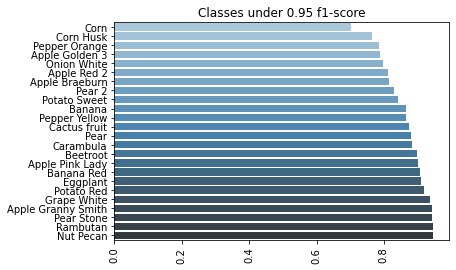

In [32]:
def plot_lowest_by_metric(metric: str, report, threshold: int=0.9):
  bottom_rank = rank_by_metric(report, metric, False)
  under_threshold = {k: v for k, v in bottom_rank if v < threshold}
  data = pd.Series(under_threshold)
  
  plt.title(f"Classes under {threshold} {metric}")
  sns.barplot(y=data.index,
              x=data.values,
              palette='Blues_d')

  plt.xticks(rotation=90)

plot_lowest_by_metric('f1-score', report, threshold=0.95)

### Confusion matrix
The confusion matrix for this amount of classes (131) is not realistically displayable, but the numerical values contained in it are still worth checking.

By focusing on the weakest items by recall metric, an idea of what they are mistaken with is valuable.

First a function needs to be designed to find the data from the confusion matrix for the targets of values (the weakest recall items) and then the class names can be retrieved from their numerical indexes.

In [33]:
cm = confusion_matrix(targets, predictions)
bottom5_numbers = [class_names.index(k) for k, v in weakest_recall[:5]]

In [34]:
def find_N_bottom_mistaken_labels(cm, num: int=5):
  """Find a specific number of items that get mistaken for others,
  and return the result in a dataframe"""
  # Get the indexes of items from list of tuples
  bottom_indexes = [class_names.index(k) for k, v in weakest_recall[:num]]
  label_mistakes = {}
  
  # Loop through the confusion matrix rows 
  # that coincides with the worst recall values
  for i, target_predictions in enumerate(cm[bottom_indexes]):
      target_index = bottom_indexes[i]
      # Find the classes that get mistaken for the target
      mistakes = mistaken_with_target(target_index, target_predictions)

      # Save result in dictionary
      label_mistakes[get_name_from_index(target_index)] = mistakes
      print() 
      
  df = pd.DataFrame(label_mistakes)
  return df.T

def mistaken_with_target(target_index, target_predictions, threshold: int=0):
  """Find the classes that get mistaken for the target"""

  print(f"{get_name_from_index(target_index)} was mistaken for:")
  mistakes = {}

  # Loop through the predictions (from confusion matrix)
  for j, guess_times in enumerate(target_predictions):
      # Only keep the values above a threshold
      # (that are mistaken more than <threshold> times)
      if guess_times > threshold:
          mistaken_for = j
          
          # Do not include the correct predictions
          if mistaken_for != target_index:
            # Retrieve name from index
              mistaken_class = get_name_from_index(mistaken_for)
              # Save and display result
              mistakes[mistaken_class] = guess_times
              print(f"{mistaken_class}: {guess_times} times") 

  return mistakes

def find_target_mistaken_labels(cm, target_predictions: str):
  """Find the classes that get mistaken for a specific target"""
  target_index = class_names.index(target_predictions)
  target_predictions = cm[target_index]
  
  mistakes = mistaken_with_target(target_index, target_predictions)
  target_class = get_name_from_index(target_index)
  data = pd.DataFrame({target_class: mistakes})
  return data.T

GRID_WIDTH = 3
GRID_HEIGHT = 2

data = find_N_bottom_mistaken_labels(cm, GRID_WIDTH*GRID_HEIGHT)

Corn Husk was mistaken for:
Grape White 4: 4 times
Hazelnut: 7 times
Grape White: 22 times
Melon Piel de Sapo: 1 times
Pear 2: 1 times
Peach Flat: 6 times
Tomato not Ripened: 6 times
Pear Stone: 6 times
Ginger Root: 5 times

Corn was mistaken for:
Physalis with Husk: 3 times
Peach 2: 8 times
Potato White: 5 times
Onion White: 39 times

Pepper Orange was mistaken for:
Cucumber Ripe 2: 14 times
Pepper Yellow: 69 times

Apple Braeburn was mistaken for:
Apple Red 2: 51 times

Pear 2 was mistaken for:
Apple Pink Lady: 33 times
Banana Lady Finger: 5 times
Onion White: 29 times

Potato Sweet was mistaken for:
Potato White: 3 times
Potato Red: 26 times
Beetroot: 11 times
Ginger Root: 1 times



Plotting this data gives a clearer idea of the mistakes made by the classifier.



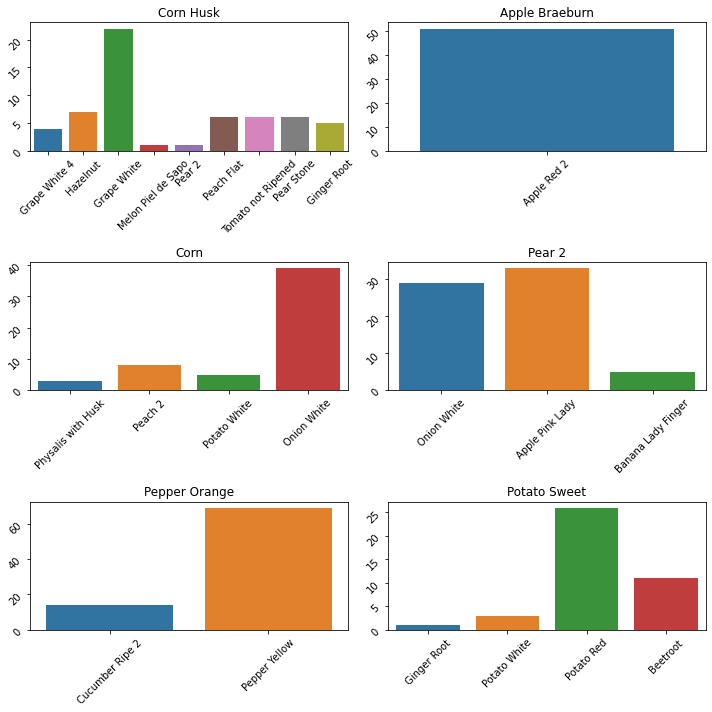

In [35]:
def plot_mistakes(width, height, data: pd.DataFrame):
  fig, axes = plt.subplots(width,height, figsize=(10,10))
  counter = 0

  for i, row in data.iterrows():
      x = counter%width
      y = counter//width
      ax = axes[x][y]

      row.dropna(inplace=True)
      sns.barplot(x=row.index,
                  y=row.values,
                  ax=ax)

      counter += 1
      ax.title.set_text(row.name)
      ax.tick_params(labelrotation=45)
      fig.tight_layout()
      fig.show()

plot_mistakes(GRID_WIDTH, GRID_HEIGHT, data)

Single value of interest can also be investigated.

Corn Husk was mistaken for:
Grape White 4: 4 times
Hazelnut: 7 times
Grape White: 22 times
Melon Piel de Sapo: 1 times
Pear 2: 1 times
Peach Flat: 6 times
Tomato not Ripened: 6 times
Pear Stone: 6 times
Ginger Root: 5 times


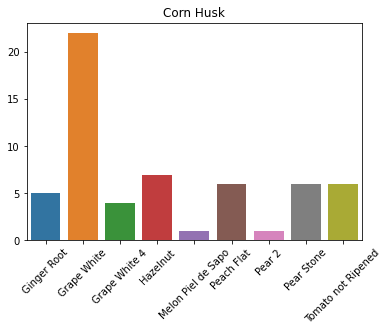

In [45]:
LABEL_NAME = 'Corn Husk'

def plot_single_misclassified_label(name: str):
  data = find_target_mistaken_labels(cm, name).iloc[0]
  sns.barplot(x=data.index,
              y=data.values)
  plt.title(name)
  plt.xticks(rotation=45)
  plt.show()

plot_single_misclassified_label(LABEL_NAME)

It is even possible to look at the pictures that were misclassified for this specific label.

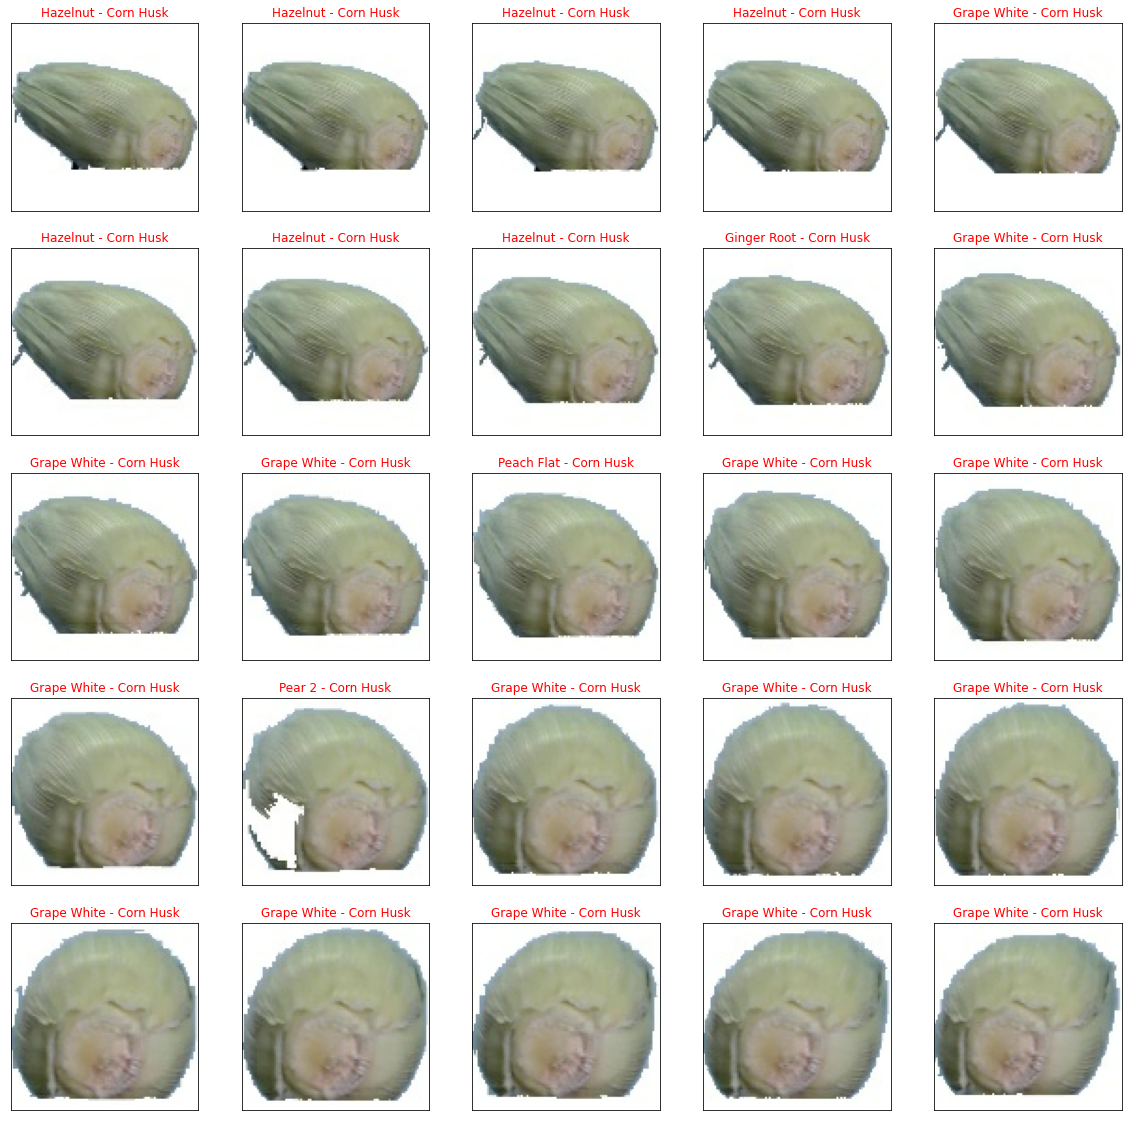

In [54]:
grid_matching_predictions(only_wrong=True,
                          target_class=LABEL_NAME)

In [48]:
# To download model from colab
!zip -r /content/CNN.zip /content/CNN4

  adding: content/CNN4/ (stored 0%)
  adding: content/CNN4/keras_metadata.pb (deflated 93%)
  adding: content/CNN4/variables/ (stored 0%)
  adding: content/CNN4/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/CNN4/variables/variables.index (deflated 73%)
  adding: content/CNN4/assets/ (stored 0%)
  adding: content/CNN4/saved_model.pb (deflated 90%)


## Conclusion
A full data science pipeline was built to address the main aim of this project; from data gathering to data cleaning, model building and evaluation.

The selected model obtained a accuracy score of 97.5% on an unseen test set. 

Although best practices were followed by dividing validation and test sets, it is worth noting that they both come from the same shuffled original dataset and are mostly similar. This guarantess that the score obtain was not overfitted only on validation set while trying multiple run and hyperparameters but it does not guarantee that it would scale well on real-life data.

In order to guarantee the performance of the model in real scenarios the aim of the model should be explicited. It usually belong to the Business Understanding step that is the first step in a Data Science project. This would help gathering some data from expected situations the model would be used to, to better evaluate success.

Futhermore the model could have been improved by more attemps at hyper-parameters tuning or slightly different architectures; however this notebook being for assessement and the model being of no real uses, it is unecessary to spend more resources into fine-tuning it.

Possible solutions and improvements have been explored already, as well as creating the tools to train, save, load and evaluate or vizualize results, that could be used with any models' architecture.

No method were designed to try many different hyper-parameters combinations as the optimal result was already know from literature reviews on the matter. The current notebook was run on a free version of Colab, making it complicated to save and load models with limited access to cloud GPUs, therefore trying more options was hardly a possibility. This is why doing research work can be valuable as there is no need to retry what was already attempted by others, and often choosing a good strategy is better than tedious efforts at exhaustive trials.

In conclusion the goal that was set initially of being able to discriminate being 131 classes of fruits and vegetables and correctly classify them, is successful. 

## References
[1] https://medium.com/starschema-blog/transfer-learning-the-dos-and-donts-165729d66625

[2] https://towardsdatascience.com/deep-learning-optimizers-436171c9e23f 

[3] https://gombru.github.io/2018/05/23/cross_entropy_loss/

[4] https://medium.com/apprentice-journal/evaluating-multi-class-classifiers-12b2946e755b